# Computational Drug Discovery (EDA)

In [1]:
conda install -c rdkit rdkit

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


### Load Bioactivity Data

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

In [4]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active


In [5]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [6]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [7]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
4690,CHEMBL4293155,2440.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...
4691,CHEMBL4282558,2540.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...
4692,CHEMBL4281727,3810.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...
4693,CHEMBL4292349,3460.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...


### Calculate Lipinski descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

In [8]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### Calculate Descriptors

In [9]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [10]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
4690,511.150,7.07230,2.0,3.0
4691,511.150,7.07230,2.0,3.0
4692,555.601,7.18140,2.0,3.0
4693,521.702,6.32710,2.0,5.0


### Combine the two DataFrames

In [11]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
4690,511.150,7.07230,2.0,3.0
4691,511.150,7.07230,2.0,3.0
4692,555.601,7.18140,2.0,3.0
4693,521.702,6.32710,2.0,5.0


In [12]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate


In [13]:
df_combined = pd.concat([df, df_lipinski], axis=1)

In [14]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.80320,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.55460,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.35740,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.70690,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.09530,0.0,6.0
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate,511.150,7.07230,2.0,3.0
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate,511.150,7.07230,2.0,3.0
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate,555.601,7.18140,2.0,3.0
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate,521.702,6.32710,2.0,5.0


### Convert IC50 value to pIC50

To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

- Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10$^{-9}$
- Take the molar value and apply -log10
- Delete the standard_value column and create a new pIC50 column

In [15]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [16]:
df_combined.standard_value.describe()

count    4.695000e+03
mean     3.210931e+12
std      1.189580e+14
min      6.000000e-03
25%      1.250000e+02
50%      2.246000e+03
75%      1.753000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

Capping the values to 100,000,000

In [17]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [18]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,intermediate,511.150,7.07230,2.0,3.0,2440.0
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,intermediate,511.150,7.07230,2.0,3.0,2540.0
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,intermediate,555.601,7.18140,2.0,3.0,3810.0
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,intermediate,521.702,6.32710,2.0,5.0,3460.0


In [19]:
df_norm.standard_value_norm.describe() #Max value now is only 100m

count    4.695000e+03
mean     3.276494e+05
std      4.718369e+06
min      6.000000e-03
25%      1.250000e+02
50%      2.246000e+03
75%      1.753000e+04
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [20]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,intermediate,511.150,7.07230,2.0,3.0,5.612610
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,intermediate,511.150,7.07230,2.0,3.0,5.595166
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,intermediate,555.601,7.18140,2.0,3.0,5.419075
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,intermediate,521.702,6.32710,2.0,5.0,5.460924


In [21]:
df_norm.pIC50.describe()

count    4695.000000
mean        5.820864
std         1.552813
min         1.000000
25%         4.756219
50%         5.648590
75%         6.903090
max        11.221849
Name: pIC50, dtype: float64

### Removing the 'intermediate' bioactivity class

In [23]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
4675,CHEMBL4284261,CCN(C)Cc1cc(N)ccc1O.Cl.Cl,inactive,180.251,1.4261,2.0,3.0,3.015428
4676,CHEMBL4276921,CN(C)Cc1cc(N)ccc1O.Cl.Cl,inactive,166.224,1.0360,2.0,3.0,2.813467
4677,CHEMBL4292574,CNCc1cc(N)ccc1O.Cl.Cl,inactive,152.197,0.6938,3.0,3.0,3.476904
4685,CHEMBL4292766,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3F)CC2...,active,494.695,6.5580,2.0,3.0,6.124939


## Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

In [24]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### Simple Frequency Plot of the 2 biactivity classes

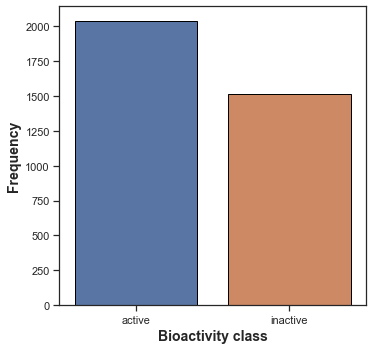

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot of MW versus LogP

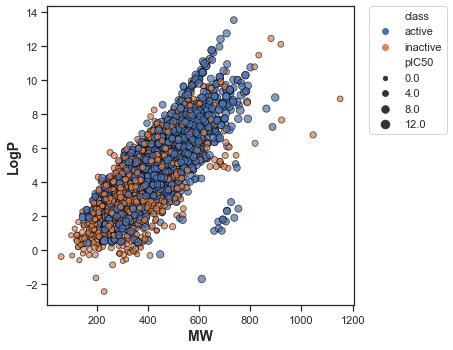

In [30]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

## Box Plots

### pIC50 Value

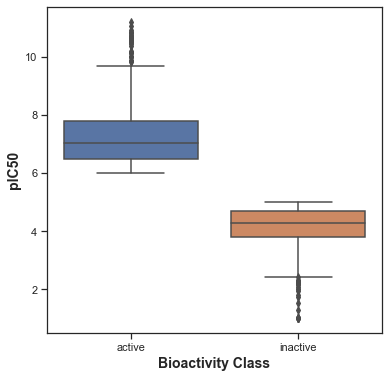

In [31]:
plt.figure(figsize=(6,6))

sns.boxplot(x='class', y='pIC50', data = df_2class)

plt.xlabel("Bioactivity Class", fontsize=14, fontweight='bold')
plt.ylabel("pIC50", fontsize=14, fontweight='bold')

plt.savefig('plot_pIC50.pdf') 
# We can see a clear difference because inactive <= 5 and active >= 6

#### Statistical Analysis | Mann-Whitney U Test

In [32]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [33]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


### MW

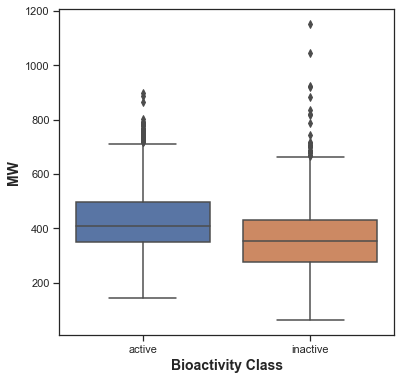

In [35]:
plt.figure(figsize=(6,6))

sns.boxplot(x='class', y='MW', data = df_2class)

plt.xlabel("Bioactivity Class", fontsize=14, fontweight='bold')
plt.ylabel("MW", fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

### LogP

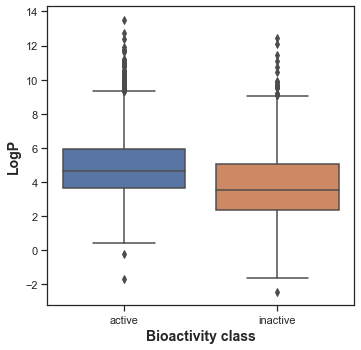

In [36]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [37]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1041900.0,2.318667e-61,0.05,Different distribution (reject H0)


### NumHDonors

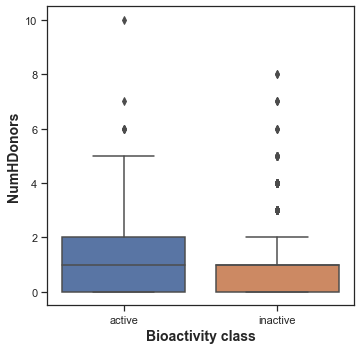

In [38]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [39]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1361005.5,2.520096e-10,0.05,Different distribution (reject H0)


### NumHAcceptors

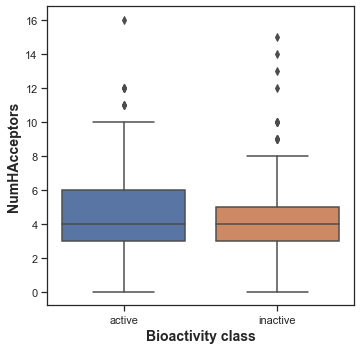

In [40]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [41]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1407572.5,0.000004,0.05,Different distribution (reject H0)


### Interpretation of Statistical Results

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited statistically significant difference between the **actives** and **inactives.**